<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/81_Pro_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%94%D0%97_Pytorch_2_PRO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Используя любую предобученную сеть из библиотеки Pytorch, напишите нейронную сеть, сегментирующую изображение. Используйте базу движения по улицам Лондона.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загружаем zip файл
!unzip -q '/content/drive/MyDrive/Базы/London_img.zip' -d '/content/London'

In [ ]:
from torchvision import models # здесь лежат предобученные сетки

#import argparse
from types import SimpleNamespace # простой класс, где можно прописать параметры
import json

# Для визуализации
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import time
import scipy
from google.colab import files
import os
import matplotlib.image as img

# Библиотеки Pytorch
import torch
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет
from torch.autograd import Variable # для автоматического дифференциатора

from tensorflow.keras.preprocessing import image

In [ ]:
# Задаем пути к нашим данным
path = '/content/London/London_img/images_prepped_train/' 
listID = os.listdir(path)

labels = '/content/London/London_img/annotations_prepped_train/'
labelsID = os.listdir(labels)
print(listID)
print(labelsID)

['0006R0_f02760.png', '0016E5_06090.png', '0006R0_f02040.png', '0016E5_06480.png', '0016E5_04920.png', '0001TP_006900.png', '0016E5_02100.png', '0016E5_07500.png', '0016E5_01170.png', '0016E5_04680.png', '0006R0_f03840.png', '0016E5_08610.png', '0016E5_07590.png', '0016E5_08370.png', '0001TP_007440.png', '0001TP_006840.png', '0006R0_f03300.png', '0006R0_f03930.png', '0016E5_05880.png', '0016E5_07770.png', '0016E5_05700.png', '0016E5_02220.png', '0016E5_08580.png', '0016E5_05130.png', '0016E5_06510.png', '0006R0_f01080.png', '0016E5_05910.png', '0006R0_f01740.png', '0001TP_007110.png', '0016E5_07440.png', '0006R0_f01890.png', '0001TP_006990.png', '0006R0_f02850.png', '0001TP_007080.png', '0016E5_01950.png', '0001TP_007350.png', '0016E5_07530.png', '0001TP_007410.png', '0006R0_f03150.png', '0006R0_f03570.png', '0016E5_06120.png', '0006R0_f01320.png', '0006R0_f02670.png', '0006R0_f02010.png', '0016E5_08430.png', '0016E5_08250.png', '0006R0_f01050.png', '0001TP_007740.png', '0001TP_007830.

In [ ]:
path_test = '/content/London/London_img/annotations_prepped_test'
listID_test = os.listdir(path_test)

labels_test = '/content/London/London_img/images_prepped_test'
labelsID_test = os.listdir(labels_test)

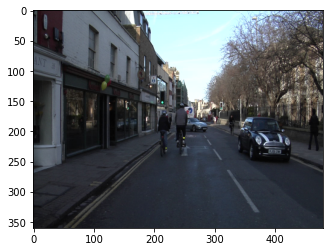

In [ ]:
new = '/content/London/London_img/images_prepped_test/0016E5_07959.png'
plt.imshow(Image.open(new))

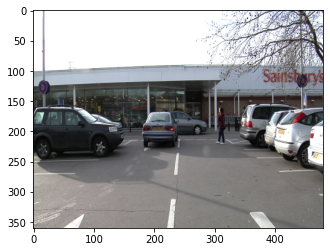

In [ ]:
plt.imshow(Image.open(path + listID[0]));

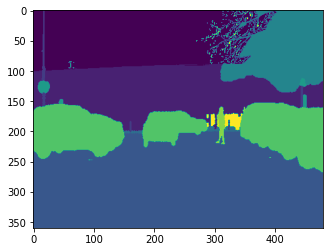

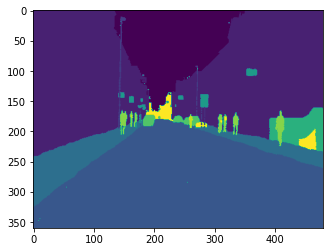

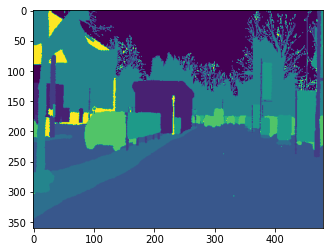

In [ ]:
for i in labelsID[:3]:
  plt.imshow(Image.open(labels+i))
  plt.show()

In [ ]:
# Ohe
target = torch.randint(0, 10, (1,))
one_hot = torch.nn.functional.one_hot(target, 10)
one_hot, target

(tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]), tensor([6]))

In [ ]:
arr = Image.open(labels+labelsID[0])
arr = np.array(arr)
arr.shape

(360, 480)

In [ ]:
num_class = 12
img_width = 176
img_height = 240

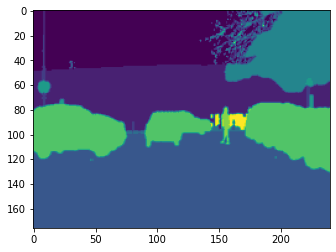

In [ ]:
plt.imshow(torchvision.transforms.functional.resize(Image.open(labels+labelsID[0]), (img_width,img_height)))
plt.show()

In [ ]:
# Создаем класс для собственных данных, наследуя свойства стандартного датасета
class CustomDataset(data.Dataset):
    def __init__(self, listID, labelsID, path, labels, num_class, img_width, img_height, transforms = None): 
        # Инициализируем атрибуты (они абсолютно производные. У вас они могут быть совсем другими)
        self.listID = listID # listID список имен каждого экземпляра
        self.labels = labels # labels - то, что скормим как yTrain
        self.transforms = transforms # если нужны какие-то преобразования
        self.path = path # путь, где лежат данные
        self.labelsID = labelsID
        self.num_class = num_class
        self.img_width = img_width
        self.img_height = img_height

    def __getitem__(self, index):        
        # Открываем папку с данными (можно использовать numpy.fromfile, PIL.Image.open)
        ID = self.listID[index] # итерируем по каждому элементу в списке
        image_ = np.array(torchvision.transforms.functional.resize(Image.open(path+ID), (img_width,img_height))) # извлекаем картинку по его ID

        # Открываем папку с данными (можно использовать numpy.fromfile, PIL.Image.open)
        ID_Y = self.labelsID[index] # итерируем по каждому элементу в списке
        image_Y = np.array(torchvision.transforms.functional.resize(Image.open(labels+ID_Y), (img_width,img_height))) # извлекаем картинку по его ID

        # Если transforms заполнено, то:
        if self.transforms:
            image_ = self.transforms(image_) # то, что лежит в transforms применяем к картинку
        trainX = image_ # наша картинка уходит в xTrain для этой итерации

        trainY = image_Y # лейбл для этой картинки уходит в yTrain

        # Возвращаем пару экзмепляр-метка
        return trainX, trainY 

    def __len__(self):
        # Здесь общий размер вашего датасета
        return len(listID)

In [ ]:
# Задаем набор трансформаций mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                            std=(0.229, 0.224, 0.225))])

In [ ]:
customData = CustomDataset(listID, labelsID, path, labels, num_class, img_width, img_height, transform)

trainLoader = torch.utils.data.DataLoader(dataset=customData,
                                           batch_size=2, 
                                           shuffle=True,
                                           num_workers=0)

In [ ]:
dataiter = iter(trainLoader)
images = dataiter.__next__()
images[0].shape


torch.Size([2, 3, 176, 240])

In [ ]:
images = dataiter.__next__()
images[1].shape

torch.Size([2, 176, 240])

In [ ]:
resnet50 = torchvision.models.segmentation.fcn_resnet50(pretrained=True, progress=True, num_classes=21, aux_loss=None)
resnet50

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
class Classifier(nn.Module): 
    def __init__(self):
        super(Classifier, self).__init__()
        self.cl = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1, inplace=False),
            nn.Conv2d(512, 12, kernel_size=(1, 1), stride=(1, 1)))
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cl(x)
        # out = self.softmax(out)
        return out


class Aux_classifier(nn.Module): 
    def __init__(self):
        super(Aux_classifier, self).__init__()
        self.aux_cl = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1, inplace=False),
            nn.Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1)))
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.aux_cl(x)
        # out = self.softmax(out)
        return out

model_cl = Classifier()
model_aux_cl = Aux_classifier()

In [ ]:
model_cl.train(), model_aux_cl.train()

(Classifier(
   (cl): Sequential(
     (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(512, 12, kernel_size=(1, 1), stride=(1, 1))
   )
 ), Aux_classifier(
   (aux_cl): Sequential(
     (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
   )
 ))

In [ ]:
for param in resnet50.parameters(): # поскольку мы будем тренировать под наш сет только последний слой
    param.requires_grad = False # не будем обновлять веса всей сети. Заморозим их

# Заменим последний слой для настройки под наш датасет
resnet50.classifier = model_cl
resnet50.aux_classifier = model_aux_cl

In [ ]:
# Проверка, если GPU включен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
resnet50.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
def dice_coef(y_pred, y_true):
    # Возвращаем площадь пересечения деленную на площадь объединения двух областей
    return (2. * torch.sum(y_true * y_pred) + 1.) / (torch.sum(y_true) + torch.sum(y_pred) + 1.) 

def ohe_tr(label, num_class=12, dimension=4):
    y = torch.nn.functional.one_hot(label, num_class)
    y = torch.transpose(torch.transpose(y, dimension-1,dimension-2), dimension-3,dimension-2)
    return y

history_loss = []
history_dice = []

batchSize = 128 # Зададим размер батча
numEpochs = 10 # Зададим количество эпох для обучения
learningRate = 0.00001 # Зададим параметр learningRate для оптимайзера

In [ ]:
criterion = nn.CrossEntropyLoss() #.to(device) # Функция ошибки
optimizer = torch.optim.Adam(resnet50.classifier.parameters(), lr=learningRate)# Оптимизатор. Поскольку тренируем только слой классификатор, то его параметры и подаем на вход

# Обучим наш последний слой
for epoch in range(numEpochs):
    for i, (images, label) in enumerate(trainLoader):          
        optimizer.zero_grad() # обнуляем градиенты
        outputs = resnet50(images.to(device)) # подаем наше изображение на вход

        outputs_ = nn.functional.softmax(outputs['out'], dim=1)

        loss = criterion(outputs_, label.to(device, torch.long)) # считаем ошибку (torch.int64)
        loss.backward() # берем производную
        optimizer.step() # делаем шаг оптимизатором

        dice_c = dice_coef(outputs_, ohe_tr(label.to(device, torch.long)))

        history_loss.append(loss.item())
        history_dice.append(dice_c.item())
        
        if (i+1) % 10 == 0:
            print('Эпоха: [%d/%d], Шаг: [%d/%d], Потеря: %.4f, Dice: %.4f' 
                  % (epoch+1, numEpochs, i+1, len(customData)//batchSize, loss, dice_c.item()))

Эпоха: [1/10], Шаг: [10/2], Потеря: 2.3525, Dice: 0.2194
Эпоха: [1/10], Шаг: [20/2], Потеря: 2.2695, Dice: 0.3089
Эпоха: [1/10], Шаг: [30/2], Потеря: 2.1710, Dice: 0.4122
Эпоха: [1/10], Шаг: [40/2], Потеря: 2.1769, Dice: 0.4077
Эпоха: [1/10], Шаг: [50/2], Потеря: 2.0755, Dice: 0.5126
Эпоха: [1/10], Шаг: [60/2], Потеря: 2.1105, Dice: 0.4785
Эпоха: [1/10], Шаг: [70/2], Потеря: 2.0093, Dice: 0.5838
Эпоха: [1/10], Шаг: [80/2], Потеря: 2.0962, Dice: 0.4939
Эпоха: [1/10], Шаг: [90/2], Потеря: 2.0278, Dice: 0.5640
Эпоха: [1/10], Шаг: [100/2], Потеря: 2.1034, Dice: 0.4893
Эпоха: [1/10], Шаг: [110/2], Потеря: 2.0189, Dice: 0.5743
Эпоха: [1/10], Шаг: [120/2], Потеря: 1.9782, Dice: 0.6176
Эпоха: [1/10], Шаг: [130/2], Потеря: 1.9815, Dice: 0.6125
Эпоха: [1/10], Шаг: [140/2], Потеря: 2.0163, Dice: 0.5791
Эпоха: [1/10], Шаг: [150/2], Потеря: 2.0713, Dice: 0.5226
Эпоха: [1/10], Шаг: [160/2], Потеря: 1.9983, Dice: 0.5992
Эпоха: [1/10], Шаг: [170/2], Потеря: 2.1411, Dice: 0.4534
Эпоха: [1/10], Шаг: [18

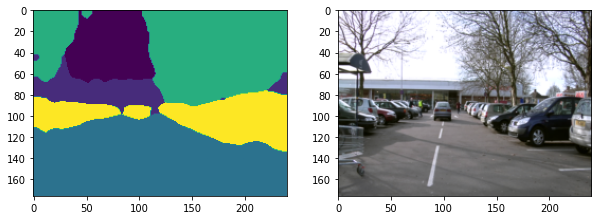

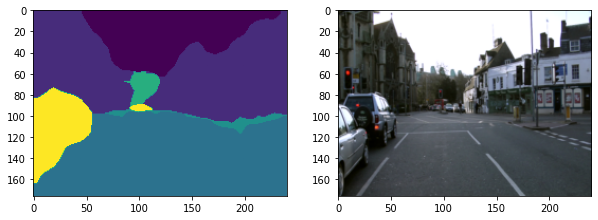

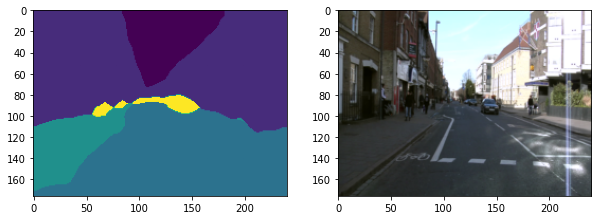

In [ ]:
for i in range(3):
    dataiter = iter(trainLoader)
    images = dataiter.__next__()

    out = resnet50(images[0].to(device))['out']

    out_ = nn.functional.softmax(out, dim=1)
    out_ = torch.argmax(out_, 1)[0]


    inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                                        std=[1/0.229, 1/0.224, 1/0.255])

    inv_tensor = inv_normalize(images[0][0])
    img_ = inv_tensor.cpu().numpy().transpose(1,2,0)
    img_[img_ > 1.] = 1.
    img_[img_ < 0] = 0.

    out_ = out_.cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(out_)
    plt.subplot(222)
    plt.imshow(img_)
plt.show()